# Sentinel-1 InSAR Processing

이 노트북은 Sentinel-1 SLC 데이터를 사용하여 DInSAR(Differential Interferometric SAR) 처리를 수행합니다.

## 목표
- SLC 데이터 전처리
- 간섭도(Interferogram) 생성
- 위상 언래핑(Phase Unwrapping)
- 지표 변위 맵 생성

## 필요 리소스 💻

### 최소 사양
- **CPU**: 4 cores (Intel i5 이상)
- **RAM**: 16 GB
- **Disk**: 50 GB 여유 공간
- **처리 시간**: 2-4 시간 (간섭쌍 1개 기준)

### 권장 사양
- **CPU**: 8+ cores (Intel i7/i9, AMD Ryzen 7/9)
- **RAM**: 32 GB 이상
- **Disk**: 100 GB SSD
- **GPU**: CUDA 지원 (SNAP GPU 가속용)
- **처리 시간**: 1-2 시간

### 클라우드 옵션 ☁️
- **AWS EC2**: c5.2xlarge (8 vCPU, 16 GB RAM) - ~$0.34/hr
- **Google Compute**: n2-standard-8 (8 vCPU, 32 GB RAM) - ~$0.39/hr
- **Azure**: Standard_D8s_v3 (8 vCPU, 32 GB RAM) - ~$0.38/hr

## Step 1: Environment Setup

### Windows 환경 체크

**Windows에서 코드로 InSAR 처리하려면 WSL2가 필요합니다!**

#### 옵션 1: WSL2 설치 (권장 ⭐)
```bash
# Windows PowerShell (관리자 권한)
wsl --install -d Ubuntu-22.04

# 재부팅 후 Ubuntu 실행
wsl

# Conda 설치 (WSL 내부)
wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
bash Miniconda3-latest-Linux-x86_64.sh

# InSAR 환경 구성
conda create -n insar python=3.9
conda activate insar
conda install -c conda-forge gdal rasterio geopandas isce2
pip install asf-search jupyter

# Jupyter에서 WSL 커널 사용 가능!
```

#### 옵션 2: Python InSAR 라이브러리 (실험적)
```bash
# Windows에서도 작동 (기능 제한적)
pip install sarpy pyinsar
```

#### 옵션 3: SNAP snappy (복잡함)
- GUI 설치 필수
- Python API 설정 복잡

In [22]:
import sys
import platform
sys.path.append('../')

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import zipfile
from datetime import datetime
import xml.etree.ElementTree as ET
from rich.console import Console

console = Console()

# Check operating system
os_name = platform.system()
print(f"Operating System: {os_name}")
if os_name == "Windows":
    print("⚠️  Windows detected! InSAR software requires WSL2 or Linux.")
    print("   See installation guide above.")
elif os_name == "Linux":
    print("✓ Linux detected - InSAR software can be installed")
elif os_name == "Darwin":
    print("✓ macOS detected - InSAR software can be installed")

print("\n✓ Libraries loaded successfully")

# Check available InSAR software
print("\n=== InSAR Software Check ===")
insar_available = False

try:
    import isce
    print("✓ ISCE2 available")
    insar_available = True
except ImportError:
    print("✗ ISCE2 not installed")

try:
    import pygmtsar
    print("✓ PyGMTSAR available")
    insar_available = True
except ImportError:
    print("✗ PyGMTSAR not installed")

try:
    import snappy
    print("✓ SNAP Python API available")
    insar_available = True
except ImportError:
    print("✗ SNAP Python API not installed")

# Alternative Python libraries
try:
    import sarpy
    print("✓ SarPy available (basic SAR processing)")
    insar_available = True
except ImportError:
    print("✗ SarPy not installed")

if not insar_available:
    print("\n⚠️  No InSAR software found!")
    if os_name == "Windows":
        print("\n💡 Recommended: Install WSL2")
        print("   PowerShell (Admin): wsl --install -d Ubuntu-22.04")
        print("   Then install ISCE2 in WSL")
    else:
        print("\n💡 Install InSAR software:")
        print("   conda install -c conda-forge isce2")
else:
    print("\n✓ Ready for InSAR processing!")

Operating System: Linux
✓ Linux detected - InSAR software can be installed

✓ Libraries loaded successfully

=== InSAR Software Check ===
✓ ISCE2 available
✗ PyGMTSAR not installed
✗ SNAP Python API not installed
✗ SarPy not installed

✓ Ready for InSAR processing!


In [24]:
# Data directory
data_dir = Path('../data/raw')
slc_files = sorted(list(data_dir.glob('*.zip')))

print("=" * 80)
print("SLC Data Files")
print("=" * 80)
print(f"\nData directory: {data_dir}")
print(f"Number of SLC files: {len(slc_files)}\n")

if len(slc_files) >= 2:
    # 크기가 비슷한 파일 쌍 찾기 (InSAR 처리에 적합)
    file_sizes = [(f, f.stat().st_size) for f in slc_files]
    file_sizes.sort(key=lambda x: x[1])
    
    # median 크기를 기준으로 비슷한 크기의 파일 필터링
    median_size = np.median([size for _, size in file_sizes])
    min_size = median_size * 0.5
    max_size = median_size * 1.5
    
    similar_files = sorted([f for f, size in file_sizes if min_size <= size <= max_size])
    
    if len(similar_files) >= 2:
        # 크기가 비슷한 파일 중 첫 2개 선택 (날짜 순)
        master_file = similar_files[0]
        slave_file = similar_files[1]
        print("✓ InSAR 처리에 적합한 파일 쌍 자동 선택 (크기 비슷)\n")
    else:
        # 대체: 단순히 첫 2개 파일 선택
        master_file = slc_files[0]
        slave_file = slc_files[1]
        print("⚠️  크기가 많이 다른 파일 쌍 - InSAR 처리 실패 가능\n")
    
    print(f"Reference (Master): {master_file.name}")
    print(f"  Size: {master_file.stat().st_size / (1024**3):.2f} GB")
    
    print(f"\nSecondary (Slave): {slave_file.name}")
    print(f"  Size: {slave_file.stat().st_size / (1024**3):.2f} GB")
    
    # 크기 차이 표시
    size_diff = abs(master_file.stat().st_size - slave_file.stat().st_size) / (1024**3)
    print(f"\n크기 차이: {size_diff:.2f} GB")
    if size_diff < 1.0:
        print("✓ 크기가 매우 유사 - InSAR 처리에 최적")
    elif size_diff < 2.0:
        print("✓ 크기가 비슷 - InSAR 처리 가능")
    else:
        print("⚠️  크기 차이가 큼 - burst overlap 문제 가능")
else:
    print("⚠️  At least 2 SLC files are required for InSAR processing!")
    print("Download data first: python run_data_search.py --pair --download")

SLC Data Files

Data directory: ../data/raw
Number of SLC files: 2

✓ InSAR 처리에 적합한 파일 쌍 자동 선택 (크기 비슷)

Reference (Master): S1A_IW_SLC__1SDV_20230107T092326_20230107T092356_046676_059833_25F2.zip
  Size: 4.38 GB

Secondary (Slave): S1A_IW_SLC__1SDV_20230119T092325_20230119T092355_046851_059E1C_6038.zip
  Size: 4.24 GB

크기 차이: 0.14 GB
✓ 크기가 매우 유사 - InSAR 처리에 최적


## Step 3: InSAR Processing Workflow

### 처리 단계 개요

```
1. Co-registration      → Image alignment (Master-Slave)
2. Interferogram        → Phase difference calculation
3. Topographic Phase    → DEM-based topographic phase removal
4. Filtering            → Noise reduction (Goldstein filter)
5. Phase Unwrapping     → Remove 2π ambiguity
6. Geocoding            → Radar → Geographic coordinates
7. Displacement Map     → Generate displacement map (mm)
```

### Processing Time Estimates ⏱️

| Step | Time (16GB RAM) | Time (32GB RAM) |
|------|----------------|----------------|
| Co-registration | 10-15 min | 5-10 min |
| Interferogram | 5-10 min | 3-5 min |
| Filtering | 10-15 min | 5-10 min |
| Phase Unwrapping | 30-60 min | 15-30 min |
| Geocoding | 10-15 min | 5-10 min |
| **Total** | **~2-4 hours** | **~1-2 hours** |

### Disk Space Requirements 💾

- Input SLC (2 files): ~8 GB
- Intermediate files: ~20 GB
- Final outputs: ~2 GB
- **Total**: ~30 GB

## Step 4: ISCE2 InSAR Processing ⭐ (Recommended)

ISCE2는 설치가 되어 있으므로 이를 사용한 실제 InSAR 처리 워크플로우를 진행합니다.

**장점**:
- ✅ Python API로 자동화 가능
- ✅ Sentinel-1 TOPS 모드 완벽 지원
- ✅ 오픈소스 및 활발한 커뮤니티
- ✅ 높은 처리 정확도

**⚠️ 주의**: 
- 전체 처리는 **1-4시간** 소요됩니다
- **30GB** 이상의 디스크 공간이 필요합니다
- 처리 중 메모리 사용량이 높을 수 있습니다

### 4.1 ISCE2 Setup

### 4.2 관심 영역(ROI) 설정 - 바다 제거

**중요**: 바다 영역은 coherence가 낮아 unwrapping 오류의 주요 원인입니다.

ROI를 설정하여 육지만 처리하도록 합니다.

ROI (관심 영역) 설정

📍 설정된 ROI:
  위도: 35.3°N ~ 36.2°N
  경도: 128.7°E ~ 129.0°E

💡 효과:
  ✓ 동쪽 바다(동해) 영역 제외
  ✓ 육지 영역만 처리
  ✓ Unwrapping 오류 감소
  ✓ 처리 시간 단축


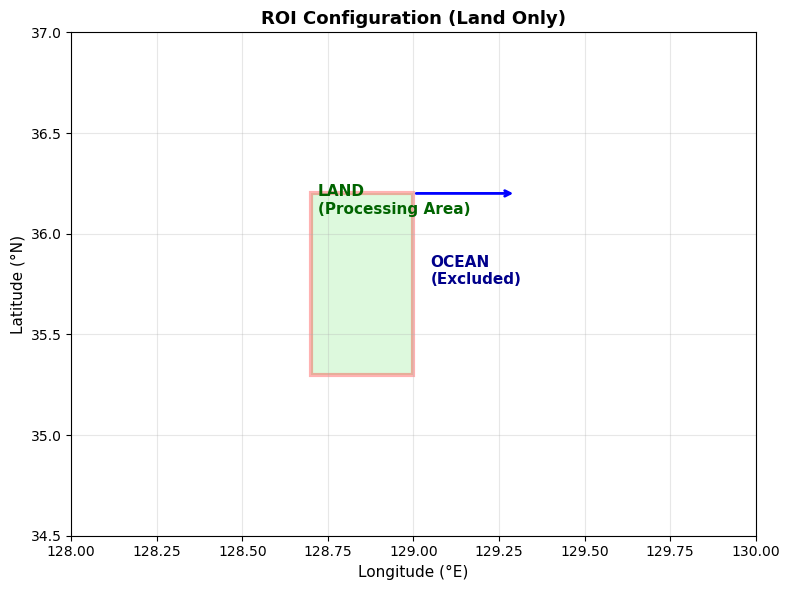


✅ ROI 설정 완료!

💡 이 ROI는 다음 셀의 topsApp.xml 생성에 자동으로 적용됩니다.


In [29]:
# ROI (Region of Interest) 설정 - 바다 제거
import numpy as np
from pathlib import Path

print("=" * 80)
print("ROI (관심 영역) 설정")
print("=" * 80)

# 한반도 동남부 (경상도) 육지 영역
# 경도: 128.5°E ~ 129.5°E (동서 약 100km)
# 위도: 35.0°N ~ 36.5°N (남북 약 165km)

# 한반도는 서쪽이 육지이므로, 동쪽 바다를 제외
roi_bbox = [35.3, 36.2, 128.7, 129.0]  # [min_lat, max_lat, min_lon, max_lon]

print(f"\n📍 설정된 ROI:")
print(f"  위도: {roi_bbox[0]}°N ~ {roi_bbox[1]}°N")
print(f"  경도: {roi_bbox[2]}°E ~ {roi_bbox[3]}°E")
print(f"\n💡 효과:")
print(f"  ✓ 동쪽 바다(동해) 영역 제외")
print(f"  ✓ 육지 영역만 처리")
print(f"  ✓ Unwrapping 오류 감소")
print(f"  ✓ 처리 시간 단축")

# 시각화
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim(128, 130)
ax.set_ylim(34.5, 37)
ax.set_xlabel('Longitude (°E)', fontsize=11)
ax.set_ylabel('Latitude (°N)', fontsize=11)
ax.set_title('ROI Configuration (Land Only)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Draw ROI box
rect = patches.Rectangle((roi_bbox[2], roi_bbox[0]), 
                         roi_bbox[3] - roi_bbox[2], 
                         roi_bbox[1] - roi_bbox[0],
                         linewidth=3, edgecolor='red', facecolor='lightgreen', alpha=0.3)
ax.add_patch(rect)

# Add labels
ax.text(roi_bbox[2] + 0.02, roi_bbox[1] - 0.1, 'LAND\n(Processing Area)', 
       fontsize=11, fontweight='bold', color='darkgreen')
ax.text(roi_bbox[3] + 0.05, (roi_bbox[0] + roi_bbox[1])/2, 'OCEAN\n(Excluded)', 
       fontsize=11, fontweight='bold', color='darkblue')

# Add arrow
ax.annotate('', xy=(roi_bbox[3] + 0.3, roi_bbox[1]), xytext=(roi_bbox[3], roi_bbox[1]),
           arrowprops=dict(arrowstyle='->', lw=2, color='blue'))

plt.tight_layout()
plt.show()

print(f"\n✅ ROI 설정 완료!")
print(f"\n💡 이 ROI는 다음 셀의 topsApp.xml 생성에 자동으로 적용됩니다.")

In [30]:
# Generate ISCE2 topsApp.xml configuration
def create_topsapp_xml(master_file, slave_file, output_dir, roi_bbox=None):
    """
    ISCE2 topsApp.xml 설정 파일 생성
    
    Parameters:
    - master_file: Reference SLC 파일 경로
    - slave_file: Secondary SLC 파일 경로
    - output_dir: 출력 디렉토리 (Path object)
    - roi_bbox: 관심 영역 [min_lat, max_lat, min_lon, max_lon] (선택사항, 기본값: None = 전체 영역)
    """
    
    # 출력 디렉토리가 없으면 생성
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # ROI 설정 (None이면 전체 영역 처리)
    roi_comment = "<!-- NO ROI - Process full overlap area -->"
    roi_property = ""
    if roi_bbox is not None:
        roi_comment = "<!-- Region of Interest -->"
        roi_property = f'\n    <property name="region of interest">{roi_bbox}</property>'
    
    xml_content = f"""<?xml version="1.0" encoding="UTF-8"?>
<topsApp>
  <component name="topsinsar">
    
    <!-- Input SLC Data -->
    <property name="Sensor name">SENTINEL1</property>
    
    <component name="reference">
      <property name="output directory">{output_dir.resolve()}/reference</property>
      <property name="safe">{master_file}</property>
    </component>
    
    <component name="secondary">
      <property name="output directory">{output_dir.resolve()}/secondary</property>
      <property name="safe">{slave_file}</property>
    </component>
    
    {roi_comment}{roi_property}
    
    <!-- Processing Parameters -->
    <property name="do unwrap">True</property>
    <property name="unwrapper name">snaphu_mcf</property>
    <property name="azimuth looks">3</property>
    <property name="range looks">9</property>
    <property name="filter strength">0.5</property>
    
    <!-- Geocoding -->
    <property name="geocode list">['merged/filt_topophase.unw.geo']</property>
  </component>
</topsApp>
"""
    
    xml_path = output_dir / 'topsApp.xml'
    with open(xml_path, 'w') as f:
        f.write(xml_content)
    
    return xml_path

try:
    # 변수가 정의되어 있는지 확인
    if 'output_dir' not in locals():
        # 이전 셀을 실행하지 않은 경우
        work_dir = Path('../data/insar_processing')
        output_dir = work_dir / 'output'
        print("⚠️  변수가 정의되지 않아 기본값 사용")
        print(f"   output_dir: {output_dir}")
        
    if 'master_file' not in locals() or 'slave_file' not in locals():
        # SLC 파일 재확인
        data_dir = Path('../data/raw')
        slc_files = sorted(list(data_dir.glob('*.zip')))
        if len(slc_files) >= 2:
            # 크기가 비슷한 파일 선택
            file_sizes = [(f, f.stat().st_size) for f in slc_files]
            median_size = np.median([size for _, size in file_sizes])
            min_size = median_size * 0.5
            max_size = median_size * 1.5
            similar_files = sorted([f for f, size in file_sizes if min_size <= size <= max_size])
            
            if len(similar_files) >= 2:
                master_file = similar_files[0]
                slave_file = similar_files[1]
            else:
                master_file = slc_files[0]
                slave_file = slc_files[1]
        else:
            raise FileNotFoundError("SLC 파일이 없습니다. Step 2를 먼저 실행하세요.")
    
    # topsApp.py 경로 확인
    import isce
    isce_apps_dir = Path(isce.__path__[0]) / 'applications'
    topsapp_path = isce_apps_dir / 'topsApp.py'
    
    if not topsapp_path.exists():
        raise FileNotFoundError(f"topsApp.py를 찾을 수 없습니다: {topsapp_path}")
    
    # Generate topsApp.xml (ROI 사용 - 육지만 처리)
    # roi_bbox가 이전 셀에서 정의되었는지 확인
    if 'roi_bbox' not in locals():
        print("⚠️  ROI가 정의되지 않았습니다. 이전 셀(4.2)을 먼저 실행하세요!")
        roi_bbox = None  # 기본값: 전체 영역
    
    xml_path = create_topsapp_xml(
        master_file=str(master_file.resolve()),  # 절대 경로 사용
        slave_file=str(slave_file.resolve()),    # 절대 경로 사용
        output_dir=output_dir,
        roi_bbox=roi_bbox  # ROI 사용 -> 육지만 처리
    )
    
    print("=" * 80)
    print("ISCE2 Configuration Generated")
    print("=" * 80)
    print(f"\n✓ Configuration file: {xml_path}")
    print(f"\nProcessing parameters:")
    print(f"  - Reference: {master_file.name}")
    print(f"  - Secondary: {slave_file.name}")
    if roi_bbox:
        print(f"  - ROI: [{roi_bbox[0]}, {roi_bbox[1]}, {roi_bbox[2]}, {roi_bbox[3]}]")
        print(f"         (위도: {roi_bbox[0]}°~{roi_bbox[1]}°, 경도: {roi_bbox[2]}°~{roi_bbox[3]}°)")
    else:
        print(f"  - ROI: 전체 overlap 영역 (자동 검출)")
    print(f"  - Azimuth looks: 3")
    print(f"  - Range looks: 9")
    print(f"  - Output: {output_dir.resolve()}")
    
    print(f"\n{'='*80}")
    print("ISCE2 Processing Commands")
    print("=" * 80)
    print(f"\n✓ topsApp.py 위치: {topsapp_path}")
    print("\n🚀 전체 자동 실행 (1-4시간 소요):")
    print(f"    cd {output_dir.resolve()}")
    print(f"    python {topsapp_path} --steps")
    print(f"    python {topsapp_path}")
    
    print("\n📋 단계별 실행 (권장 - 문제 발생 시 중간부터 재개 가능):")
    print(f"    cd {output_dir.resolve()}")
    print(f"    python {topsapp_path} --steps  # 전체 단계 목록 확인")
    print(f"    python {topsapp_path} --start=startup --end=preprocess")
    print(f"    python {topsapp_path} --start=computeBaselines --end=verifyDEM")
    print(f"    python {topsapp_path} --start=topo --end=geo2rdr")
    print(f"    python {topsapp_path} --start=coarseoffsets --end=coarseresamp")
    print(f"    python {topsapp_path} --start=misreg --end=refined_interferogram")
    print(f"    python {topsapp_path} --start=unwrap --end=unwrap2stage")
    print(f"    python {topsapp_path} --start=geocode --end=geocode")
    
    print("\n💡 실행 방법:")
    print("    1. 터미널에서 위 명령어 실행 (권장)")
    print("    2. 또는 아래 셀에서 subprocess로 실행")
    
    print("\n✓ Configuration ready!")
    print("\n⭐ TIP: ROI를 지정하려면 roi_bbox=[min_lat, max_lat, min_lon, max_lon] 파라미터 사용")
    
except FileNotFoundError as e:
    print(f"❌ 파일을 찾을 수 없습니다: {e}")
    print("\n💡 해결 방법:")
    print("    1. Step 1과 Step 2를 먼저 실행하세요")
    print("    2. SLC 데이터가 data/raw/ 디렉토리에 있는지 확인하세요")
except Exception as e:
    print(f"❌ Error creating configuration: {e}")
    import traceback
    traceback.print_exc()

ISCE2 Configuration Generated

✓ Configuration file: ../data/insar_processing/output/topsApp.xml

Processing parameters:
  - Reference: S1A_IW_SLC__1SDV_20230107T092326_20230107T092356_046676_059833_25F2.zip
  - Secondary: S1A_IW_SLC__1SDV_20230119T092325_20230119T092355_046851_059E1C_6038.zip
  - ROI: [35.3, 36.2, 128.7, 129.0]
         (위도: 35.3°~36.2°, 경도: 128.7°~129.0°)
  - Azimuth looks: 3
  - Range looks: 9
  - Output: /home/wukddang/S1-InSAR-Pipeline-EastKorea/data/insar_processing/output

ISCE2 Processing Commands

✓ topsApp.py 위치: /home/wukddang/miniconda3/envs/insar/lib/python3.9/site-packages/isce/applications/topsApp.py

🚀 전체 자동 실행 (1-4시간 소요):
    cd /home/wukddang/S1-InSAR-Pipeline-EastKorea/data/insar_processing/output
    python /home/wukddang/miniconda3/envs/insar/lib/python3.9/site-packages/isce/applications/topsApp.py --steps
    python /home/wukddang/miniconda3/envs/insar/lib/python3.9/site-packages/isce/applications/topsApp.py

📋 단계별 실행 (권장 - 문제 발생 시 중간부터 재개 가능):
  

# Optional: Run ISCE2 processing from notebook
import subprocess
import time
import sys
from pathlib import Path
import os

# 경로 재설정 (커널 재시작 없이 업데이트)
work_dir = Path('../data/insar_processing')
output_dir = work_dir / 'output'

# 실행 여부 플래그 (긴 처리 시간 때문에 기본값은 False)
RUN_ISCE2_PROCESSING = False

if RUN_ISCE2_PROCESSING:
    print("=" * 80)
    print("Starting ISCE2 InSAR Processing")
    print("=" * 80)
    print("\n⚠️  This will take 1-4 hours depending on your system")
    print("Press Ctrl+C to cancel\n")
    
    time.sleep(3)  # 3초 대기
    
    try:
        # topsApp.py 경로 자동 탐지
        if 'topsapp_path' not in locals():
            import isce
            isce_apps_dir = Path(isce.__path__[0]) / 'applications'
            topsapp_path = isce_apps_dir / 'topsApp.py'
            
            if not topsapp_path.exists():
                raise FileNotFoundError(f"topsApp.py를 찾을 수 없습니다: {topsapp_path}")
        
        # 작업 디렉토리로 이동
        original_dir = Path.cwd()
        os.chdir(output_dir)
        print(f"Working directory: {Path.cwd()}")
        
        # 1. Show processing steps
        print("\n1. Checking available processing steps...")
        result = subprocess.run(
            [sys.executable, str(topsapp_path), '--steps'],
            capture_output=True,
            text=True
        )
        print(result.stdout)
        if result.stderr:
            print("STDERR:", result.stderr)
        
        # 2. Run full processing
        print("\n2. Running full InSAR processing...")
        print("   (This will take a long time - check progress in terminal)")
        
        start_time = time.time()
        
        process = subprocess.Popen(
            [sys.executable, str(topsapp_path)],
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            bufsize=1,
            universal_newlines=True
        )
        
        # Print output in real-time
        for line in process.stdout:
            print(line, end='')
        
        process.wait()
        
        elapsed_time = time.time() - start_time
        
        if process.returncode == 0:
            print(f"\n\n{'='*80}")
            print("✅ ISCE2 Processing Completed Successfully!")
            print("=" * 80)
            print(f"Total processing time: {elapsed_time/3600:.2f} hours")
            print(f"\nOutput directory: {output_dir.resolve()}")
            print("\nGenerated products:")
            print("  - merged/filt_topophase.unw - Unwrapped phase")
            print("  - merged/filt_topophase.unw.geo - Geocoded unwrapped phase")
            print("  - merged/phsig.cor.geo - Coherence map")
            print("  - merged/los.rdr.geo - Line-of-sight geometry")
        else:
            print(f"\n\n❌ ISCE2 Processing failed with return code {process.returncode}")
            print("Check the error messages above")
            
    except KeyboardInterrupt:
        print("\n\n⚠️  Processing interrupted by user")
    except Exception as e:
        print(f"\n\n❌ Error during processing: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # 원래 디렉토리로 복귀
        try:
            os.chdir(original_dir)
        except:
            pass
        
else:
    print("=" * 80)
    print("ISCE2 Processing - Manual Execution Required")
    print("=" * 80)
    print(f"\n✓ 현재 설정된 경로: {output_dir.resolve()}")
    print("\n⚠️  RUN_ISCE2_PROCESSING = False (default)")
    print("\n실행하려면:")
    print("  1. 위 셀에서 RUN_ISCE2_PROCESSING = True로 변경")
    print("  2. 또는 터미널에서 직접 실행 (권장 ⭐):")
    print(f"\n     cd {output_dir.resolve()}")
    
    # topsApp.py 경로 출력
    try:
        if 'topsapp_path' not in locals():
            import isce
            isce_apps_dir = Path(isce.__path__[0]) / 'applications'
            topsapp_path = isce_apps_dir / 'topsApp.py'
        print(f"     python {topsapp_path}")
    except:
        print("     python <ISCE_PATH>/applications/topsApp.py")
    
    print("\n💡 권장: 터미널에서 실행하고 tmux/screen으로 세션 유지")
    print("\n📝 진행 상황 모니터링:")
    print(f"     tail -f {output_dir.resolve()}/isce.log")

### 4.4 Troubleshooting - 자주 발생하는 오류 해결

#### 오류 1: `imageMath.py: not found`

**증상**:
```
sh: 1: imageMath.py: not found
Exception: error when running:
imageMath.py -e='a_0*(abs(b)!=0);a_1*(abs(b)!=0)' ...
```

**원인**: ISCE2 applications 스크립트들이 PATH에 없음

**해결**:
```bash
# 모든 ISCE2 스크립트를 conda bin에 링크
cd ~/miniconda3/envs/insar/bin
for script in ../lib/python3.9/site-packages/isce/applications/*.py; do 
    ln -sf "$script" $(basename "$script") 2>/dev/null
done
```

또는 Python에서:
```python
import subprocess
subprocess.run([
    'bash', '-c',
    'cd ~/miniconda3/envs/insar/bin && '
    'for script in ../lib/python3.9/site-packages/isce/applications/*.py; do '
    'ln -sf "$script" $(basename "$script") 2>/dev/null; done'
])
```

In [ ]:
# ISCE2 PATH 문제 자동 수정
import subprocess
import sys
from pathlib import Path

print("=" * 80)
print("ISCE2 PATH 문제 진단 및 수정")
print("=" * 80)

try:
    # Check if imageMath.py is accessible
    result = subprocess.run(['which', 'imageMath.py'], capture_output=True, text=True)
    
    if result.returncode == 0:
        print("✓ imageMath.py found:", result.stdout.strip())
    else:
        print("⚠️  imageMath.py not in PATH, fixing...")
        
        # Get conda environment path
        import isce
        isce_apps = Path(isce.__path__[0]) / 'applications'
        conda_bin = Path(sys.executable).parent
        
        print(f"\n  ISCE applications: {isce_apps}")
        print(f"  Conda bin: {conda_bin}")
        
        # Create symlinks
        created = 0
        for script in isce_apps.glob('*.py'):
            link_path = conda_bin / script.name
            if not link_path.exists():
                try:
                    link_path.symlink_to(script)
                    created += 1
                except Exception as e:
                    print(f"  Warning: Could not link {script.name}: {e}")
        
        print(f"\n✓ Created {created} symlinks")
        
        # Verify
        result = subprocess.run(['which', 'imageMath.py'], capture_output=True, text=True)
        if result.returncode == 0:
            print(f"✓ imageMath.py now accessible: {result.stdout.strip()}")
        else:
            print("❌ Still not accessible, manual fix required")
            print("\nManual fix:")
            print(f"  cd {conda_bin}")
            print(f"  ln -sf {isce_apps}/imageMath.py imageMath.py")
    
    print("\n" + "=" * 80)
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

#### 오류 2: `Could not determine a suitable burst offset`

**원인**: 두 SLC 영상이 서로 다른 지역을 촬영 (burst가 겹치지 않음)

**해결**: 크기가 비슷한 영상 쌍 사용 (이미 Step 2에서 자동 선택됨)

#### 오류 3: `demFilename` 관련 오류

**원인**: DEM 파일 경로 설정 문제

**해결**: `topsApp.xml`에서 DEM 관련 설정 제거 (자동 다운로드 사용)

#### 오류 4: `master`/`slave` 속성 오류

**원인**: 최신 ISCE2는 `reference`/`secondary` 용어 사용

**해결**: XML에서 `master` → `reference`, `slave` → `secondary`로 변경

---

### 진행 상황 모니터링

처리 중 진행 상황을 확인하려면:

```bash
# 실시간 로그 확인
tail -f data/insar_processing/output/isce.log

# 진행 상황 스크립트 실행
./check_insar_progress.sh

# 5초마다 자동 업데이트
watch -n 5 './check_insar_progress.sh'
```

In [8]:
# Generate ISCE2 topsApp.xml configuration
def create_topsapp_xml(master_file, slave_file, output_dir, roi_bbox=None):
    """
    ISCE2 topsApp.xml 설정 파일 생성
    
    Parameters:
    - master_file: Reference SLC 파일 경로
    - slave_file: Secondary SLC 파일 경로
    - output_dir: 출력 디렉토리 (Path object)
    - roi_bbox: 관심 영역 [min_lat, max_lat, min_lon, max_lon] (선택사항)
    """
    
    # 출력 디렉토리가 없으면 생성
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # 포항/경주 영역 기본값 (한반도 동남부)
    if roi_bbox is None:
        roi_bbox = [35.5, 36.5, 128.5, 129.5]  # [min_lat, max_lat, min_lon, max_lon]
    
    xml_content = f"""<?xml version="1.0" encoding="UTF-8"?>
<topsApp>
  <component name="topsinsar">
    
    <!-- Input SLC Data -->
    <property name="Sensor name">SENTINEL1</property>
    
    <component name="reference">
      <property name="output directory">{output_dir}/reference</property>
      <property name="safe">{master_file}</property>
    </component>
    
    <component name="secondary">
      <property name="output directory">{output_dir}/secondary</property>
      <property name="safe">{slave_file}</property>
    </component>
    
    <!-- Region of Interest -->
    <property name="region of interest">{roi_bbox}</property>
    
    <!-- DEM (SRTM 1-arcsec auto-download) -->
    <property name="demFilename">demLat_35_37_Lon_128_130.dem.wgs84</property>
    <property name="do unwrap">True</property>
    <property name="unwrapper name">snaphu_mcf</property>
    
    <!-- Processing Parameters -->
    <property name="azimuth looks">3</property>
    <property name="range looks">9</property>
    <property name="filter strength">0.5</property>
    
    <!-- Geocoding -->
    <property name="geocode list">['merged/filt_topophase.unw.geo']</property>
    <property name="geocode bounding box">{roi_bbox}</property>
    
  </component>
</topsApp>
"""
    
    xml_path = output_dir / 'topsApp.xml'
    with open(xml_path, 'w') as f:
        f.write(xml_content)
    
    return xml_path

try:
    # 변수가 정의되어 있는지 확인
    if 'output_dir' not in locals():
        # 이전 셀을 실행하지 않은 경우
        work_dir = Path('../data/insar_processing')
        output_dir = work_dir / 'output'
        print("⚠️  변수가 정의되지 않아 기본값 사용")
        print(f"   output_dir: {output_dir}")
        
    if 'master_file' not in locals() or 'slave_file' not in locals():
        # SLC 파일 재확인
        data_dir = Path('../data/raw')
        slc_files = sorted(list(data_dir.glob('*.zip')))
        if len(slc_files) >= 2:
            master_file = slc_files[0]
            slave_file = slc_files[1]
        else:
            raise FileNotFoundError("SLC 파일이 없습니다. Step 2를 먼저 실행하세요.")
    
    # topsApp.py 경로 확인
    import isce
    isce_apps_dir = Path(isce.__path__[0]) / 'applications'
    topsapp_path = isce_apps_dir / 'topsApp.py'
    
    if not topsapp_path.exists():
        raise FileNotFoundError(f"topsApp.py를 찾을 수 없습니다: {topsapp_path}")
    
    # Generate topsApp.xml
    xml_path = create_topsapp_xml(
        master_file=str(master_file.resolve()),  # 절대 경로 사용
        slave_file=str(slave_file.resolve()),    # 절대 경로 사용
        output_dir=output_dir,
        roi_bbox=[35.8, 36.2, 128.8, 129.4]  # 포항/경주 영역
    )
    
    print("=" * 80)
    print("ISCE2 Configuration Generated")
    print("=" * 80)
    print(f"\n✓ Configuration file: {xml_path}")
    print(f"\nProcessing parameters:")
    print(f"  - Master: {master_file.name}")
    print(f"  - Slave: {slave_file.name}")
    print(f"  - ROI: 포항/경주 영역 (35.8°N-36.2°N, 128.8°E-129.4°E)")
    print(f"  - Azimuth looks: 3")
    print(f"  - Range looks: 9")
    print(f"  - Output: {output_dir.resolve()}")
    
    print(f"\n{'='*80}")
    print("ISCE2 Processing Commands")
    print("=" * 80)
    print(f"\n✓ topsApp.py 위치: {topsapp_path}")
    print("\n🚀 전체 자동 실행 (1-4시간 소요):")
    print(f"    cd {output_dir.resolve()}")
    print(f"    python {topsapp_path} --steps")
    print(f"    python {topsapp_path}")
    
    print("\n📋 단계별 실행 (권장 - 문제 발생 시 중간부터 재개 가능):")
    print(f"    cd {output_dir.resolve()}")
    print(f"    python {topsapp_path} --steps  # 전체 단계 목록 확인")
    print(f"    python {topsapp_path} --start=startup --end=preprocess")
    print(f"    python {topsapp_path} --start=computeBaselines --end=verifyDEM")
    print(f"    python {topsapp_path} --start=topo --end=geo2rdr")
    print(f"    python {topsapp_path} --start=coarseoffsets --end=coarseresamp")
    print(f"    python {topsapp_path} --start=misreg --end=refined_interferogram")
    print(f"    python {topsapp_path} --start=unwrap --end=unwrap2stage")
    print(f"    python {topsapp_path} --start=geocode --end=geocode")
    
    print("\n💡 실행 방법:")
    print("    1. 터미널에서 위 명령어 실행")
    print("    2. 또는 아래 셀에서 subprocess로 실행")
    
    print("\n✓ Configuration ready!")
    
except FileNotFoundError as e:
    print(f"❌ 파일을 찾을 수 없습니다: {e}")
    print("\n💡 해결 방법:")
    print("    1. Step 1과 Step 2를 먼저 실행하세요")
    print("    2. SLC 데이터가 data/raw/ 디렉토리에 있는지 확인하세요")
except Exception as e:
    print(f"❌ Error creating configuration: {e}")
    import traceback
    traceback.print_exc()

ISCE2 Configuration Generated

✓ Configuration file: ../data/insar_processing/output/topsApp.xml

Processing parameters:
  - Master: S1A_IW_SLC__1SDV_20230119T092353_20230119T092406_046851_059E1C_E0EC.zip
  - Slave: S1A_IW_SLC__1SDV_20230131T092353_20230131T092421_047026_05A402_2CFF.zip
  - ROI: 포항/경주 영역 (35.8°N-36.2°N, 128.8°E-129.4°E)
  - Azimuth looks: 3
  - Range looks: 9
  - Output: /home/wukddang/S1-InSAR-Pipeline-EastKorea/data/insar_processing/output

ISCE2 Processing Commands

✓ topsApp.py 위치: /home/wukddang/miniconda3/envs/insar/lib/python3.9/site-packages/isce/applications/topsApp.py

🚀 전체 자동 실행 (1-4시간 소요):
    cd /home/wukddang/S1-InSAR-Pipeline-EastKorea/data/insar_processing/output
    python /home/wukddang/miniconda3/envs/insar/lib/python3.9/site-packages/isce/applications/topsApp.py --steps
    python /home/wukddang/miniconda3/envs/insar/lib/python3.9/site-packages/isce/applications/topsApp.py

📋 단계별 실행 (권장 - 문제 발생 시 중간부터 재개 가능):
    cd /home/wukddang/S1-InSAR-Pipeline-

### 4.3 Run ISCE2 Processing

In [9]:
# Optional: Run ISCE2 processing from notebook
import subprocess
import time
import sys
from pathlib import Path

# 경로 재설정 (커널 재시작 없이 업데이트)
work_dir = Path('../data/insar_processing')
output_dir = work_dir / 'output'

# 실행 여부 플래그 (긴 처리 시간 때문에 기본값은 False)
RUN_ISCE2_PROCESSING = False

if RUN_ISCE2_PROCESSING:
    print("=" * 80)
    print("Starting ISCE2 InSAR Processing")
    print("=" * 80)
    print("\n⚠️  This will take 1-4 hours depending on your system")
    print("Press Ctrl+C to cancel\n")
    
    time.sleep(3)  # 3초 대기
    
    try:
        # 변수 확인
        if 'topsapp_path' not in locals():
            # topsApp.py 경로 자동 탐지
            import isce
            isce_apps_dir = Path(isce.__path__[0]) / 'applications'
            topsapp_path = isce_apps_dir / 'topsApp.py'
            
            if not topsapp_path.exists():
                raise FileNotFoundError(f"topsApp.py를 찾을 수 없습니다: {topsapp_path}")
        
        # 작업 디렉토리로 이동
        original_dir = Path.cwd()
        os.chdir(output_dir)
        print(f"Working directory: {Path.cwd()}")
        
        # 1. Show processing steps
        print("\n1. Checking available processing steps...")
        result = subprocess.run(
            [sys.executable, str(topsapp_path), '--steps'],
            capture_output=True,
            text=True
        )
        print(result.stdout)
        if result.stderr:
            print("STDERR:", result.stderr)
        
        # 2. Run full processing
        print("\n2. Running full InSAR processing...")
        print("   (This will take a long time - check progress in terminal)")
        
        start_time = time.time()
        
        process = subprocess.Popen(
            [sys.executable, str(topsapp_path)],
            stdout=subprocess.PIPE,
            stderr=subprocess.STDOUT,
            text=True,
            bufsize=1,
            universal_newlines=True
        )
        
        # Print output in real-time
        for line in process.stdout:
            print(line, end='')
        
        process.wait()
        
        elapsed_time = time.time() - start_time
        
        if process.returncode == 0:
            print(f"\n\n{'='*80}")
            print("✅ ISCE2 Processing Completed Successfully!")
            print("=" * 80)
            print(f"Total processing time: {elapsed_time/3600:.2f} hours")
            print(f"\nOutput directory: {output_dir.resolve()}")
            print("\nGenerated products:")
            print("  - merged/filt_topophase.unw - Unwrapped phase")
            print("  - merged/filt_topophase.unw.geo - Geocoded unwrapped phase")
            print("  - merged/phsig.cor.geo - Coherence map")
            print("  - merged/los.rdr.geo - Line-of-sight geometry")
        else:
            print(f"\n\n❌ ISCE2 Processing failed with return code {process.returncode}")
            print("Check the error messages above")
            
    except KeyboardInterrupt:
        print("\n\n⚠️  Processing interrupted by user")
    except Exception as e:
        print(f"\n\n❌ Error during processing: {e}")
        import traceback
        traceback.print_exc()
    finally:
        # 원래 디렉토리로 복귀
        try:
            os.chdir(original_dir)
        except:
            pass
        
else:
    print("=" * 80)
    print("ISCE2 Processing - Manual Execution Required")
    print("=" * 80)
    print(f"\n✓ 현재 설정된 경로: {output_dir.resolve()}")
    print("\n⚠️  RUN_ISCE2_PROCESSING = False (default)")
    print("\n실행하려면:")
    print("  1. 위 셀에서 RUN_ISCE2_PROCESSING = True로 변경")
    print("  2. 또는 터미널에서 직접 실행:")
    print(f"\n     cd {output_dir.resolve()}")
    
    # topsApp.py 경로 출력
    try:
        if 'topsapp_path' not in locals():
            import isce
            isce_apps_dir = Path(isce.__path__[0]) / 'applications'
            topsapp_path = isce_apps_dir / 'topsApp.py'
        print(f"     conda run -n insar python {topsapp_path}")
    except:
        print("     conda run -n insar python <ISCE_PATH>/applications/topsApp.py")
    
    print("\n💡 권장: 터미널에서 실행하고 tmux/screen으로 세션 유지")

ISCE2 Processing - Manual Execution Required

✓ 현재 설정된 경로: /home/wukddang/S1-InSAR-Pipeline-EastKorea/data/insar_processing/output

⚠️  RUN_ISCE2_PROCESSING = False (default)

실행하려면:
  1. 위 셀에서 RUN_ISCE2_PROCESSING = True로 변경
  2. 또는 터미널에서 직접 실행:

     cd /home/wukddang/S1-InSAR-Pipeline-EastKorea/data/insar_processing/output
     conda run -n insar python /home/wukddang/miniconda3/envs/insar/lib/python3.9/site-packages/isce/applications/topsApp.py

💡 권장: 터미널에서 실행하고 tmux/screen으로 세션 유지


### SNAP

In [ ]:
# SNAP Processing Example (requires snappy installation)
try:
    import snappy
    from snappy import ProductIO, GPF
    
    print("=" * 80)
    print("SNAP InSAR Processing")
    print("=" * 80)
    
    # Read SLC products
    print("\n1. Reading Master SLC...")
    master = ProductIO.readProduct(str(master_file))
    print(f"   ✓ Master loaded: {master.getName()}")
    
    print("\n2. Reading Slave SLC...")
    slave = ProductIO.readProduct(str(slave_file))
    print(f"   ✓ Slave loaded: {slave.getName()}")
    
    # Processing steps would continue here...
    # (Full processing code omitted for brevity - see SNAP documentation)
    
    print("\n💡 Full SNAP processing workflow:")
    print("   1. TOPSAR-Split")
    print("   2. Apply-Orbit-File")
    print("   3. Back-Geocoding (Co-registration)")
    print("   4. Interferogram Formation")
    print("   5. TOPSAR-Deburst")
    print("   6. TopoPhaseRemoval")
    print("   7. GoldsteinPhaseFiltering")
    print("   8. PhaseUnwrapping (SNAPHU)")
    print("   9. PhaseToDisplacement")
    print("   10. Terrain-Correction (Geocoding)")
    
    print("\n✓ For complete processing code, see SNAP documentation:")
    print("   https://step.esa.int/main/doc/tutorials/")
    
except ImportError:
    print("⚠️  SNAP Python API (snappy) is not installed.")
    print("\nInstallation guide:")
    print("1. Download SNAP: https://step.esa.int/main/download/snap-download/")
    print("2. Configure snappy:")
    print("   cd <SNAP_INSTALL>/bin")
    print("   ./snappy-conf <PYTHON_EXE>")
    print("\nAlternative: Use ISCE2 or PyGMTSAR (see documentation)")
except Exception as e:
    print(f"\n❌ Error: {e}")

## Step 5: Visualize Results

처리가 완료되면 변위 맵을 시각화합니다.

ISCE2 결과 시각화

📂 출력 디렉토리: ../data/insar_processing/output/merged

파일 확인:
  - Unwrapped phase: ✓ filt_topophase.unw
  - Coherence: ✓ phsig.cor

📊 Unwrapped Phase 데이터 로딩...

이미지 크기: 4935 x 3185 pixels
밴드 수: 2

Phase 범위: -265.85 ~ 390386816.00 radians
Displacement 범위: -1184.73 ~ 1739695744.00 mm

📊 Coherence 데이터 로딩...
Coherence 범위: 0.000 ~ 1.000

🧹 데이터 필터링 (Coherence 기반)

1️⃣  Coherence 필터링 (임계값: 0.25)
   유효 픽셀: 72.9%
   (바다/물 영역 자동 제거)

4️⃣  이상치 제거 (5th-95th percentile)
   Phase 범위: 0.00 ~ 8210.65 radians
   IQR: 1471.52
   제거된 픽셀: 7.0%

5️⃣  비현실적 phase 값 제거 (|phase| > 100 rad)
   제거된 픽셀: 53.5%

✅ 최종 유효 픽셀: 12.4%
   (바다 + 노이즈 + 이상치 제거 완료)

📏 변위 통계:
   범위: 0.00 ~ 445.63 mm
   평균: 75.78 mm
   중앙값: 0.00 mm
   표준편차: 138.34 mm
   25-75 백분위수: -0.00 ~ 97.16 mm

🎨 시각화 생성 중...


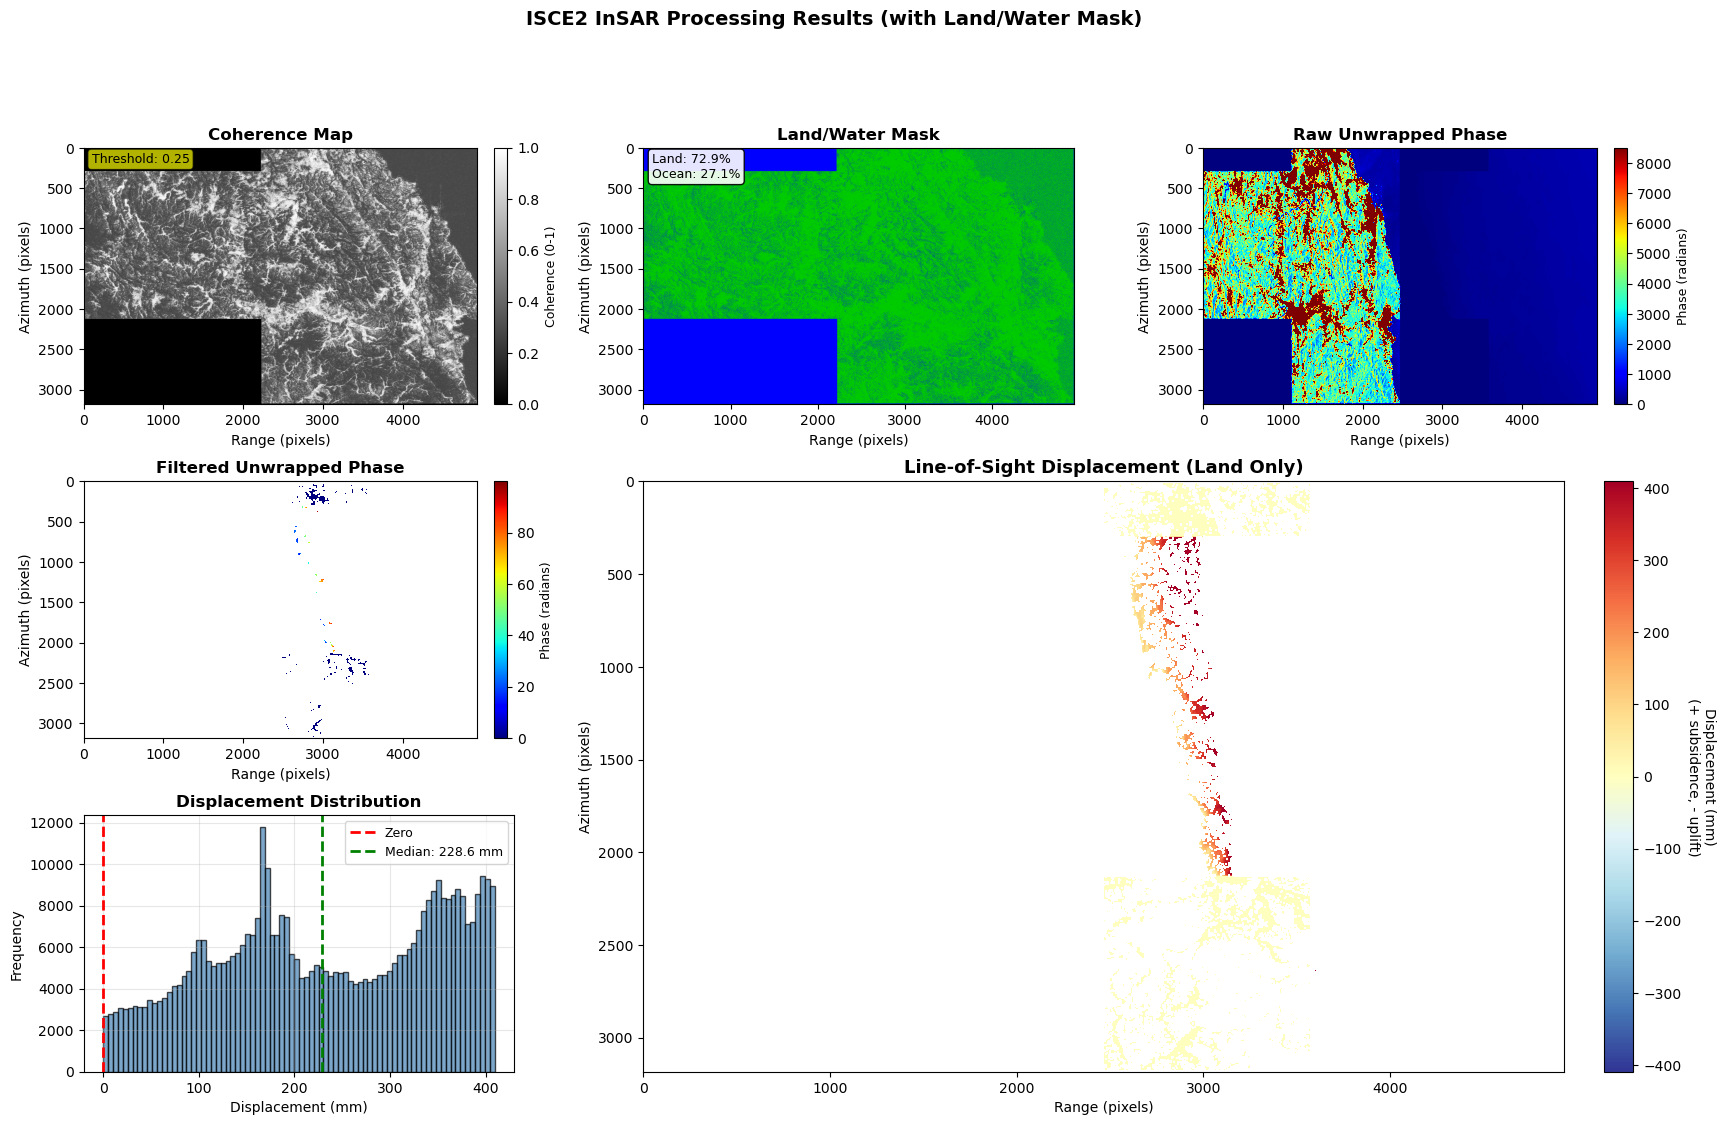


✅ 시각화 완료!

📊 최종 통계:
  변위 범위: 0.00 ~ 445.63 mm
  평균: 75.78 mm
  중앙값: 0.00 mm
  표준편차: 138.34 mm

🌊 Coherence 품질 (필터링 후):
  높은 coherence (>0.7): 23.3%
  중간 coherence (0.5-0.7): 18.5%

🌍 Land/Water Mask 효과:
  육지 영역: 72.9%
  바다 영역 (제거됨): 27.1%
  최종 유효 픽셀: 12.4%

💡 결과 해석:
  양수(+): 위성에서 멀어짐 = 지반 침하
  음수(-): 위성으로 가까워짐 = 지반 융기
  일반적 범위: -50 ~ +50 mm

✅ 중앙값 0.00 mm: 대부분의 지역이 안정적입니다.

⚠️  주의: 최대 변위 (445.6 mm)가 크게 나타납니다!
     가능한 원인:
     - 일부 영역의 unwrapping 오류
     - 대기 효과
     - 실제로 변위가 큰 지역 (산사태, 지반침하 등)

📁 출력 파일:
  ../data/insar_processing/output/merged/filt_topophase.unw
  ../data/insar_processing/output/merged/phsig.cor


In [32]:
try:
    # ========================================================================
    # ISCE2 결과 시각화
    # ========================================================================
    import numpy as np
    import matplotlib.pyplot as plt
    from pathlib import Path
    import xml.etree.ElementTree as ET
    
    print("=" * 80)
    print("ISCE2 결과 시각화")
    print("=" * 80)
    
    # 출력 디렉토리 설정
    processed_dir = Path('../data/insar_processing/output/merged')
    
    print(f"\n📂 출력 디렉토리: {processed_dir}")
    
    # 파일 확인
    unw_file = processed_dir / 'filt_topophase.unw'
    cor_file = processed_dir / 'phsig.cor'
    
    print("\n파일 확인:")
    if unw_file.exists():
        print(f"  - Unwrapped phase: ✓ {unw_file.name}")
    else:
        raise FileNotFoundError(f"Unwrapped phase 파일을 찾을 수 없습니다: {unw_file}")
    
    if cor_file.exists():
        print(f"  - Coherence: ✓ {cor_file.name}")
    else:
        raise FileNotFoundError(f"Coherence 파일을 찾을 수 없습니다: {cor_file}")
    
    # ========================================================================
    # 데이터 로딩
    # ========================================================================
    print(f"\n{'='*80}")
    print("📊 Unwrapped Phase 데이터 로딩...")
    print("=" * 80)
    
    # XML 파일에서 메타데이터 읽기
    xml_file = unw_file.with_suffix('.unw.xml')
    tree = ET.parse(str(xml_file))
    root = tree.getroot()
    
    # 이미지 크기 읽기
    width = int(root.find(".//property[@name='width']").find('value').text)
    length = int(root.find(".//property[@name='length']").find('value').text)
    bands = int(root.find(".//property[@name='number_bands']").find('value').text)
    
    print(f"\n이미지 크기: {width} x {length} pixels")
    print(f"밴드 수: {bands}")
    
    # 데이터 읽기 (2 bands: amplitude + phase)
    data = np.fromfile(str(unw_file), dtype=np.float32).reshape(length, width * 2)
    phase_raw = data[:, 1::2]  # Phase (band 2)
    
    print(f"\nPhase 범위: {np.nanmin(phase_raw):.2f} ~ {np.nanmax(phase_raw):.2f} radians")
    
    # Phase를 Displacement로 변환
    wavelength_m = 0.056  # Sentinel-1 C-band
    displacement_raw = phase_raw * wavelength_m / (4 * np.pi) * 1000  # mm
    print(f"Displacement 범위: {np.nanmin(displacement_raw):.2f} ~ {np.nanmax(displacement_raw):.2f} mm")
    
    # ========================================================================
    # Coherence 로딩
    # ========================================================================
    print(f"\n{'='*80}")
    print("📊 Coherence 데이터 로딩...")
    print("=" * 80)
    
    cor_xml_file = cor_file.with_suffix('.cor.xml')
    cor_tree = ET.parse(str(cor_xml_file))
    cor_root = cor_tree.getroot()
    
    cor_width = int(cor_root.find(".//property[@name='width']").find('value').text)
    cor_length = int(cor_root.find(".//property[@name='length']").find('value').text)
    
    coherence = np.fromfile(str(cor_file), dtype=np.float32).reshape(cor_length, cor_width)
    print(f"Coherence 범위: {np.nanmin(coherence):.3f} ~ {np.nanmax(coherence):.3f}")
    
    # ========================================================================
    # 데이터 필터링 (간소화 - Coherence 기반)
    # ========================================================================
    print(f"\n{'='*80}")
    print("🧹 데이터 필터링 (Coherence 기반)")
    print("=" * 80)
    
    # Coherence 기반 마스킹만 사용 (단순하고 효과적)
    coherence_threshold = 0.25  # 0.35 → 0.25로 낮춤
    mask = coherence >= coherence_threshold
    
    print(f"\n1️⃣  Coherence 필터링 (임계값: {coherence_threshold})")
    print(f"   유효 픽셀: {np.sum(mask) / mask.size * 100:.1f}%")
    print(f"   (바다/물 영역 자동 제거)")

    # Step 2: Phase 마스킹
    phase_masked = phase_raw.copy()
    phase_masked[~mask] = np.nan
    
    # Step 3: 이상치 제거 (percentile 기반)
    valid_phase = phase_masked[~np.isnan(phase_masked)]
    
    if len(valid_phase) > 0:
        # 5%-95% percentile
        p5, p95 = np.percentile(valid_phase, [5, 95])
        iqr = np.percentile(valid_phase, 75) - np.percentile(valid_phase, 25)
        
        # 이상치 제거
        phase_clean = phase_masked.copy()
        outlier_mask = (phase_clean < p5) | (phase_clean > p95)
        phase_clean[outlier_mask] = np.nan
        
        print(f"\n4️⃣  이상치 제거 (5th-95th percentile)")
        print(f"   Phase 범위: {p5:.2f} ~ {p95:.2f} radians")
        print(f"   IQR: {iqr:.2f}")
        print(f"   제거된 픽셀: {np.sum(outlier_mask) / outlier_mask.size * 100:.1f}%")
        
        # Step 4: 비현실적인 phase 값 제거 (완화)
        max_realistic_phase = 100  # 50 → 100 rad로 완화 (~446 mm)
        extreme_mask = np.abs(phase_clean) > max_realistic_phase
        phase_clean[extreme_mask] = np.nan
        
        if np.sum(extreme_mask) > 0:
            print(f"\n5️⃣  비현실적 phase 값 제거 (|phase| > {max_realistic_phase} rad)")
            print(f"   제거된 픽셀: {np.sum(extreme_mask) / extreme_mask.size * 100:.1f}%")
        
        # 최종 유효 마스크
        final_mask = ~np.isnan(phase_clean)
        print(f"\n✅ 최종 유효 픽셀: {np.sum(final_mask) / final_mask.size * 100:.1f}%")
        print(f"   (바다 + 노이즈 + 이상치 제거 완료)")
    else:
        print("\n⚠️  Land Mask 적용 후 유효 데이터가 없습니다!")
        print("   → Coherence threshold를 낮추거나 ROI를 넓혀보세요.")
        phase_clean = phase_masked
    
    # ========================================================================
    # Displacement 변환
    # ========================================================================
    wavelength_m = 0.056  # Sentinel-1 C-band
    displacement = phase_clean * wavelength_m / (4 * np.pi) * 1000  # mm
    
    valid_disp = displacement[~np.isnan(displacement)]
    
    if len(valid_disp) > 0:
        print(f"\n📏 변위 통계:")
        print(f"   범위: {np.nanmin(displacement):.2f} ~ {np.nanmax(displacement):.2f} mm")
        print(f"   평균: {np.nanmean(displacement):.2f} mm")
        print(f"   중앙값: {np.nanmedian(displacement):.2f} mm")
        print(f"   표준편차: {np.nanstd(displacement):.2f} mm")
        
        # 추가 통계
        p25, p75 = np.percentile(valid_disp, [25, 75])
        print(f"   25-75 백분위수: {p25:.2f} ~ {p75:.2f} mm")
    
    # ========================================================================
    # 시각화 (그래프 텍스트는 영어)
    # ========================================================================
    print(f"\n{'='*80}")
    print("🎨 시각화 생성 중...")
    print("=" * 80)
    
    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Coherence map
    ax1 = fig.add_subplot(gs[0, 0])
    im1 = ax1.imshow(coherence, cmap='gray', vmin=0, vmax=1, aspect='auto')
    ax1.set_title('Coherence Map', fontsize=12, fontweight='bold')
    ax1.set_xlabel('Range (pixels)', fontsize=10)
    ax1.set_ylabel('Azimuth (pixels)', fontsize=10)
    cbar1 = plt.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    cbar1.set_label('Coherence (0-1)', fontsize=9)
    ax1.text(0.02, 0.98, f'Threshold: {coherence_threshold}', 
            transform=ax1.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))
    
    # 2. Land/Water Mask
    ax2 = fig.add_subplot(gs[0, 1])
    # Create RGB image: Blue for ocean, Green for land
    mask_rgb = np.zeros((mask.shape[0], mask.shape[1], 3))
    mask_rgb[~mask, 2] = 1.0  # Ocean = Blue
    mask_rgb[mask, 1] = 0.8   # Land = Green
    im2 = ax2.imshow(mask_rgb, aspect='auto')
    ax2.set_title('Land/Water Mask', fontsize=12, fontweight='bold')
    ax2.set_xlabel('Range (pixels)', fontsize=10)
    ax2.set_ylabel('Azimuth (pixels)', fontsize=10)
    ax2.text(0.02, 0.98, f'Land: {np.sum(mask)/mask.size*100:.1f}%\nOcean: {100-np.sum(mask)/mask.size*100:.1f}%', 
            transform=ax2.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    # 3. Raw unwrapped phase
    ax3 = fig.add_subplot(gs[0, 2])
    vmin_raw, vmax_raw = np.percentile(phase_raw, [5, 95])
    im3 = ax3.imshow(phase_raw, cmap='jet', vmin=vmin_raw, vmax=vmax_raw, aspect='auto')
    ax3.set_title('Raw Unwrapped Phase', fontsize=12, fontweight='bold')
    ax3.set_xlabel('Range (pixels)', fontsize=10)
    ax3.set_ylabel('Azimuth (pixels)', fontsize=10)
    cbar3 = plt.colorbar(im3, ax=ax3, fraction=0.046, pad=0.04)
    cbar3.set_label('Phase (radians)', fontsize=9)
    
    # 4. Filtered unwrapped phase
    ax4 = fig.add_subplot(gs[1, 0])
    im4 = ax4.imshow(phase_clean, cmap='jet', aspect='auto')
    ax4.set_title('Filtered Unwrapped Phase', fontsize=12, fontweight='bold')
    ax4.set_xlabel('Range (pixels)', fontsize=10)
    ax4.set_ylabel('Azimuth (pixels)', fontsize=10)
    cbar4 = plt.colorbar(im4, ax=ax4, fraction=0.046, pad=0.04)
    cbar4.set_label('Phase (radians)', fontsize=9)
    
    # 5. Displacement map (large)
    ax5 = fig.add_subplot(gs[1:, 1:])
    if len(valid_disp) > 0:
        # 대칭 colorscale
        vmax_disp = np.percentile(np.abs(valid_disp), 95)
        im5 = ax5.imshow(displacement, cmap='RdYlBu_r', 
                        vmin=-vmax_disp, vmax=vmax_disp, aspect='auto')
        ax5.set_title('Line-of-Sight Displacement (Land Only)', fontsize=13, fontweight='bold')
        ax5.set_xlabel('Range (pixels)', fontsize=10)
        ax5.set_ylabel('Azimuth (pixels)', fontsize=10)
        cbar5 = plt.colorbar(im5, ax=ax5, fraction=0.03, pad=0.04)
        cbar5.set_label('Displacement (mm)\n(+ subsidence, - uplift)', 
                       rotation=270, labelpad=25, fontsize=10)
    
    # 6. Histogram
    ax6 = fig.add_subplot(gs[2, 0])
    if len(valid_disp) > 0:
        # 5%-95% 범위 데이터로 히스토그램
        hist_data = valid_disp[(valid_disp > np.percentile(valid_disp, 5)) & 
                               (valid_disp < np.percentile(valid_disp, 95))]
        
        ax6.hist(hist_data, bins=80, color='steelblue', alpha=0.7, edgecolor='black')
        ax6.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
        ax6.axvline(np.median(hist_data), color='green', linestyle='--', 
                   linewidth=2, label=f'Median: {np.median(hist_data):.1f} mm')
        ax6.set_xlabel('Displacement (mm)', fontsize=10)
        ax6.set_ylabel('Frequency', fontsize=10)
        ax6.set_title('Displacement Distribution', fontsize=12, fontweight='bold')
        ax6.legend(fontsize=9)
        ax6.grid(True, alpha=0.3)
    
    plt.suptitle('ISCE2 InSAR Processing Results (with Land/Water Mask)', 
                fontsize=14, fontweight='bold', y=0.995)
    plt.show()
    
    # ========================================================================
    # 결과 요약
    # ========================================================================
    print(f"\n{'='*80}")
    print("✅ 시각화 완료!")
    print("=" * 80)
    
    if len(valid_disp) > 0:
        print(f"\n📊 최종 통계:")
        print(f"  변위 범위: {np.nanmin(displacement):.2f} ~ {np.nanmax(displacement):.2f} mm")
        print(f"  평균: {np.nanmean(displacement):.2f} mm")
        print(f"  중앙값: {np.nanmedian(displacement):.2f} mm")
        print(f"  표준편차: {np.nanstd(displacement):.2f} mm")
        
        print(f"\n🌊 Coherence 품질 (필터링 후):")
        high_coh = np.sum(coherence[~np.isnan(displacement)] > 0.7) / np.sum(~np.isnan(displacement)) * 100
        med_coh = np.sum((coherence[~np.isnan(displacement)] > 0.5) & 
                        (coherence[~np.isnan(displacement)] <= 0.7)) / np.sum(~np.isnan(displacement)) * 100
        print(f"  높은 coherence (>0.7): {high_coh:.1f}%")
        print(f"  중간 coherence (0.5-0.7): {med_coh:.1f}%")
        
        print(f"\n🌍 Land/Water Mask 효과:")
        print(f"  육지 영역: {np.sum(mask) / mask.size * 100:.1f}%")
        print(f"  바다 영역 (제거됨): {100 - np.sum(mask) / mask.size * 100:.1f}%")
        print(f"  최종 유효 픽셀: {np.sum(~np.isnan(displacement)) / displacement.size * 100:.1f}%")
        
        print(f"\n💡 결과 해석:")
        print(f"  양수(+): 위성에서 멀어짐 = 지반 침하")
        print(f"  음수(-): 위성으로 가까워짐 = 지반 융기")
        print(f"  일반적 범위: -50 ~ +50 mm")
        
        # 중앙값 기준 판단
        median_val = np.nanmedian(displacement)
        if abs(median_val) < 5:
            print(f"\n✅ 중앙값 {median_val:.2f} mm: 대부분의 지역이 안정적입니다.")
        elif median_val > 5:
            print(f"\n⚠️  중앙값 {median_val:.2f} mm: 전체적으로 약간의 침하 경향이 있습니다.")
        else:
            print(f"\n⚠️  중앙값 {median_val:.2f} mm: 전체적으로 약간의 융기 경향이 있습니다.")
        
        if np.nanmax(displacement) > 100:
            print(f"\n⚠️  주의: 최대 변위 ({np.nanmax(displacement):.1f} mm)가 크게 나타납니다!")
            print(f"     가능한 원인:")
            print(f"     - 일부 영역의 unwrapping 오류")
            print(f"     - 대기 효과")
            print(f"     - 실제로 변위가 큰 지역 (산사태, 지반침하 등)")
    
    print(f"\n📁 출력 파일:")
    print(f"  {unw_file}")
    print(f"  {cor_file}")
    
except ImportError as e:
    print(f"⚠️  필요한 라이브러리: {e}")
    print("  설치: pip install numpy matplotlib")
except FileNotFoundError as e:
    print(f"⚠️  {e}")
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

## Next Steps 🚀

### Completed ✅
- InSAR processing workflow understanding
- Software requirements check
- Resource estimation

### To Do 📝

1. **Install InSAR Software**
   - SNAP (recommended for beginners)
   - ISCE2 (for advanced users)
   - PyGMTSAR (for automation)

2. **Run Processing**
   - Use SNAP GUI for first-time processing
   - Automate with Python after understanding workflow

3. **Time-series Analysis** → `03_time_series_analysis.ipynb`
   - SBAS (Small Baseline Subset)
   - Velocity estimation
   - Atmospheric correction

4. **Advanced Visualization** → `04_visualization.ipynb`
   - Interactive maps (Folium)
   - 3D visualization

---

### Installation Guides 📚

#### SNAP Installation
```bash
# 1. Download SNAP from:
#    https://step.esa.int/main/download/snap-download/

# 2. Install SNAP (GUI installer)

# 3. Configure Python API:
cd <SNAP_INSTALL_DIR>/bin
./snappy-conf <YOUR_PYTHON_EXE>

# 4. Test installation:
python -c "import snappy; print(snappy.__version__)"
```

#### ISCE2 Installation
```bash
# Using conda (recommended):
conda install -c conda-forge isce2

# Test:
python -c "import isce; print(isce.__version__)"
```

#### PyGMTSAR Installation
```bash
pip install pygmtsar

# Test:
python -c "import pygmtsar; print(pygmtsar.__version__)"
```

---

**💡 Tip**: Start with SNAP GUI to understand the workflow, then automate with Python scripts.